In [ ]:
%cd C:/Users/realc/OneDrive/Documents/GSOC

from utils.post_training import *
from utils.statistics import *
from utils.plotting import *
from utils.angle_encoding_script import angle_encoding
from utils.haar_noising_script import apply_haar_scrambling

import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import os
import math

import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim_func

import pennylane as qml

C:\Users\realc\OneDrive\Documents\GSOC


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
# make sure measurements/sample space makes sense in the entire pipline

In [7]:
filename = "data/QG1_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])

print("Raw data shape:", data_X.shape)

data_X = data_X.astype(np.float32)

# log + normalize
data_X = np.log1p(data_X)
data_X = data_X / data_X.max()

# map to [-1, 1]
data_X = 2.0 * data_X - 1.0

Raw data shape: (1000, 64, 64)


In [31]:
# make sure data is encoded correctly, hence encode anew for a simple feature map
dev = qml.device("default.qubit", wires=1)

# x↦(⟨X⟩,⟨Z⟩)=(sinx,cosx)
@qml.qnode(dev)
def single_qubit_embedding(x):
    """
    x: scalar in [-1, 1]
    returns: (⟨X⟩, ⟨Z⟩)
    """
    qml.RY(x, wires=0)
    return (
        qml.expval(qml.PauliX(0)),
        qml.expval(qml.PauliZ(0))
    )

def quantum_embed_image(img):
    H, W = img.shape
    qfeat = np.zeros((2, H, W), dtype=np.float32)

    for i in range(H):
        for j in range(W):
            x_val = img[i, j]
            qfeat[:, i, j] = single_qubit_embedding(x_val)

    return qfeat

N = 10
quantum_data = np.stack([
    quantum_embed_image(data_X[i]) for i in range(N)
])

quantum_data = torch.tensor(quantum_data, dtype=torch.float32)
print("Quantum data shape:", quantum_data.shape)

Quantum data shape: torch.Size([10, 2, 64, 64])


In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = TensorDataset(quantum_data)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.SiLU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(0, half, device=t.device) / half
        )
        args = t.unsqueeze(-1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.lin(emb)


class SmallConvField(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, time_emb_dim=64):
        super().__init__()
        self.time_emb = TimeEmbedding(time_emb_dim)
        self.time_proj = nn.Linear(time_emb_dim, base_ch)

        self.init_conv = nn.Conv2d(in_ch + 1, base_ch, 3, padding=1, padding_mode='circular')
        self.conv1 = nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular')
        self.conv2 = nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular')

        self.mid = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular'),
            nn.SiLU(),
            nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular'),
            nn.SiLU()
        )

        self.final = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular'),
            nn.SiLU(),
            nn.Conv2d(base_ch, in_ch, 3, padding=1, padding_mode='circular')
        )

    def forward(self, x, t):
        B, C, H, W = x.shape
        t_channel = t.view(B, 1, 1, 1).expand(-1, 1, H, W)
        h = torch.cat([x, t_channel], dim=1)

        h = F.silu(self.init_conv(h))
        h = F.silu(self.conv1(h) + h)
        h = F.silu(self.conv2(h) + h)

        h = self.mid(h)

        t_emb = self.time_emb(t)
        t_proj = self.time_proj(t_emb).view(B, -1, 1, 1)
        h = h + t_proj

        return self.final(h)

def linear_mix(x0, x1, t):
    t = t.view(-1, 1, 1, 1)
    return (1.0 - t) * x0 + t * x1

In [33]:
# Smaller but same FM model
model = SmallConvField(
    in_ch=2,        # quantum channels
    base_ch=64,
    time_emb_dim=64
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [34]:
def train_one_epoch(model, loader, optimizer, latent_std=0.2):
    model.train()
    total_loss = 0.0

    for (x0,) in loader:
        x0 = x0.to(device)
        B = x0.size(0)

        x1 = torch.randn_like(x0) * latent_std
        t = torch.rand(B, device=device)

        t_view = t.view(B, 1, 1, 1)
        x_t = (1 - t_view) * x0 + t_view * x1
        target_v = x1 - x0

        pred_v = model(x_t, t)
        loss = torch.nn.functional.mse_loss(pred_v, target_v)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B

    return total_loss / len(loader.dataset)

In [35]:
epochs = 10
loss_history_qfm = []

for epoch in range(1, epochs + 1):
    loss = train_one_epoch(model, train_loader, optimizer)
    loss_history_qfm.append(loss)
    print(f"[QFM] Epoch {epoch}: loss = {loss:.6f}")


[QFM] Epoch 1: loss = 0.522236
[QFM] Epoch 2: loss = 0.504330
[QFM] Epoch 3: loss = 0.486990
[QFM] Epoch 4: loss = 0.468587
[QFM] Epoch 5: loss = 0.448246
[QFM] Epoch 6: loss = 0.428798
[QFM] Epoch 7: loss = 0.408567
[QFM] Epoch 8: loss = 0.390693
[QFM] Epoch 9: loss = 0.371378
[QFM] Epoch 10: loss = 0.350209


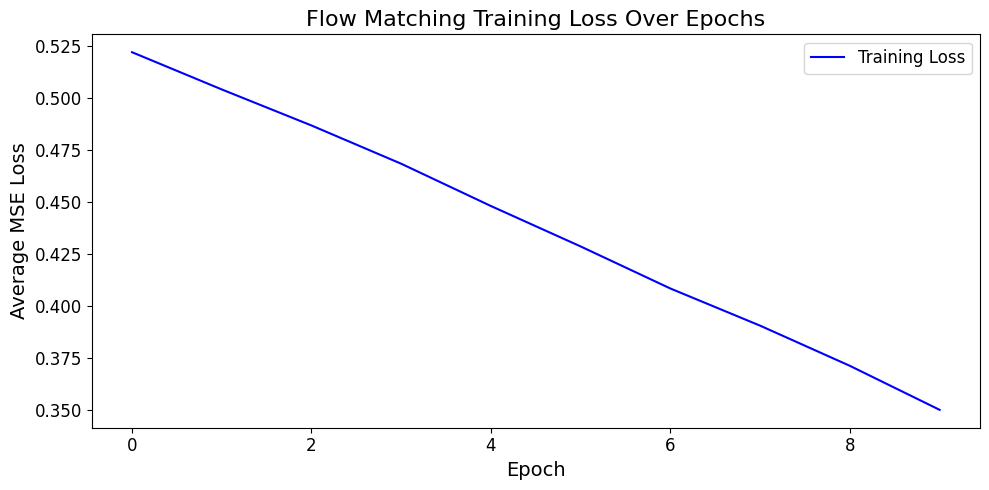

In [36]:
plt.figure(figsize=(10, 5))

plt.plot(loss_history_qfm, label='Training Loss', color='blue')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Average MSE Loss', fontsize=14)
plt.title('Flow Matching Training Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [39]:
@torch.no_grad()
def rk4_integration(model, x_init, t0=1.0, t1=0.0, steps=80):
    model.eval()
    x = x_init.clone()
    B = x.size(0)

    dt = (t1 - t0) / steps
    t = t0

    for _ in range(steps):
        t_vec = torch.full((B,), t, device=x.device)

        k1 = model(x, t_vec)
        k2 = model(x + 0.5 * dt * k1, t_vec + 0.5 * dt)
        k3 = model(x + 0.5 * dt * k2, t_vec + 0.5 * dt)
        k4 = model(x + dt * k3, t_vec + dt)

        x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt

    return x

@torch.no_grad()
def sample_quantum(model, n=10, steps=80, latent_std=0.2):
    z = torch.randn(n, 2, 64, 64, device=device) * latent_std
    x = rk4_integration(model, z, steps=steps)
    return x.cpu()

def decode_to_image(q_feats):
    return F.interpolate(
        q_feats.mean(dim=1, keepdim=True),
        size=(64, 64),
        mode="nearest"
    )

In [40]:
q_samples = sample_quantum(model)
img_samples = decode_to_image(q_samples)

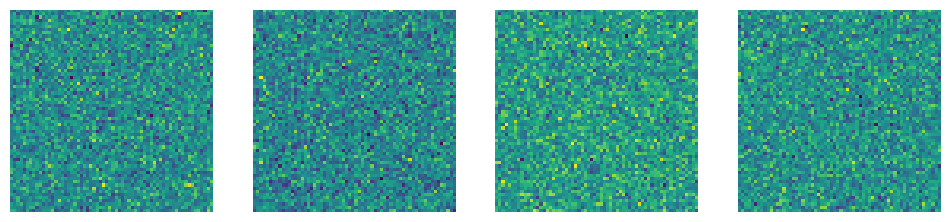

In [41]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = (img_samples[i].clamp(-1, 1) + 1) / 2
    axs[i].imshow(img.squeeze().cpu())
    axs[i].axis("off")

plt.show()

In [42]:
real_imgs = torch.tensor(data_X[:len(img_samples)]).unsqueeze(1)
fake_imgs = img_samples

def compute_ssim(real, fake):
    real = real.squeeze(1).numpy()
    fake = fake.squeeze(1).numpy()

    scores = []
    for i in range(len(real)):
        s = ssim(
            real[i],
            fake[i],
            data_range=2.0  # because images are in [-1, 1]
        )
        scores.append(s)

    return np.mean(scores), np.std(scores)

def compute_fid(real, fake):
    """
    real, fake: (N, 1, 64, 64)
    """
    real = real.view(real.size(0), -1).numpy()
    fake = fake.view(fake.size(0), -1).numpy()

    mu_r = real.mean(axis=0)
    mu_f = fake.mean(axis=0)

    cov_r = np.cov(real, rowvar=False)
    cov_f = np.cov(fake, rowvar=False)

    diff = mu_r - mu_f
    covmean = scipy.linalg.sqrtm(cov_r @ cov_f)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(cov_r + cov_f - 2 * covmean)
    return float(fid)

ssim_mean, ssim_std = compute_ssim(real_imgs, fake_imgs)
fid_score = compute_fid(real_imgs, fake_imgs)

print(f"[QFM] SSIM: {ssim_mean:.4f} ± {ssim_std:.4f}")
print(f"[QFM] FID: {fid_score:.2f}")

[QFM] SSIM: 0.0240 ± 0.0007
[QFM] FID: 3582.33
